# AI4EO challenge: Air Quality & Health Challenge

I am an introduction

## Table of contents

1. [Pre-processing](#pre-processing)

    1.1 [AOIs and target grids](#aoi-and-target-grids)    
    1.2 [Stations](#stations)    
    1.3 [CAMS](#cams)    
    1.4 [S5P](#s5p)    
    1.5 [S3](#s3)    
    1.6 [MODIS](#modis)    
    1.7 [ERA5](#era5)     
    1.8 [Land cover](#land-cover)     
    1.9 [DEM](#dem)    
    1.10 [SPOT](#spot)  
    1.11 [Data Merging](#data-merging)    

    
2. [Exploratory analysis](#exploratory-analysis)
    
3. [Modelling and validation](#modelling-and-validation)

4. [Prediction](#prediction)
    

## Pre-processing <a name="pre-processing"></a>

In [2]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType
from sentinelhub import bbox_to_dimensions

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)

In [3]:
DATA_DIR = Path('training_dataset_ita')
AOIS = ['Italy']

In [4]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

### AOI and target grids  <a name="aoi-and-target-grids"></a>

Here I think we should read the 6 target files (3 CAMS, 3 S5P) and derive boundaries, EPSG and reference grids to pre-process the rest of the data to match it.

### Stations <a name="stations"></a>

### CAMS <a name="cams"></a>
EPSG: 4326. temporal resolution: hourly. spatial resolution: North Italy: 10 km, California & South Africa: 40km.

### S5P <a name="cams"></a>

### S3 <a name="cams"></a>

## MODIS
EPSG: 4326. Spatial Resolution: 1km, Temporal resolution: Daily

In [150]:
modis_train_dir = DATA_DIR/AOIS[0]/'modis_MCD19A2'
modis_products = sorted(os.listdir(modis_train_dir))

## Load MODIS AOD - Aerosol Optical depth information
modis_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD',
                         feature=(FeatureType.DATA, 'AOD'),
                         filename=filename,
                         image_dtype=np.float32,
                         data_source='modis') 
              for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD'))]

## Load MODIS AOD - Optical Depth Quality Index
modis_qa_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD_QA',
                            feature=(FeatureType.DATA, 'AOD_QA'),
                            filename=filename,
                            image_dtype=np.float32,
                            data_source='modis') 
                 for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD_QA'))]



In [151]:
## Function to encode the MODIS QA LAYER and return mask array with just clear and high quality pixels.
def ValidData(eopatch,band,min_modis_qa):
    eopatch.data['AOD_QA'][..., band][eopatch.data['AOD_QA'][..., band] == min_modis_qa] = np.nan
    modis_AOD_QA = eopatch.data['AOD_QA'][..., band]

    qa_data = np.unique(modis_AOD_QA)
    qa_data = qa_data.astype(np.int16)
    qa_data = qa_data.tolist()
    qa_data = [x for x in qa_data if x != 0]

    for i in qa_data:
        mask811 = 0b111100000000
        mask02 =  0b000000000111
        qa811 = (i & mask811) >> 8
        qa02 = (i & mask02) >> 0
        if qa811 == 0 and qa02 == 1:
            i = float(i)
            modis_AOD_QA=np.where(modis_AOD_QA==i, 0, modis_AOD_QA)
        else:
            i = float(i)
            modis_AOD_QA=np.where(modis_AOD_QA==i, 1, modis_AOD_QA)


    return modis_AOD_QA

In [152]:
import warnings
from eolearn.core import AddFeature, MapFeatureTask, MergeFeatureTask


## Task to add masked array for AOD
feature = (FeatureType.DATA, 'AOD_Valid')
add_feature = AddFeature(feature)

## Task to add masked array for AOD
feature_mask = (FeatureType.MASK_TIMELESS, 'MASK_AOD')
add_feature_mask = AddFeature(feature_mask)


## Tasks to compute statistics of valid AOD (mean, maximum, minimum) 
mean = MapFeatureTask((FeatureType.DATA,'AOD_Valid'),  # input features
                         (FeatureType.DATA_TIMELESS,'Mean_AOD_VALID'),  # output feature
                         np.nanmean,                    # a function to apply to each feature
                         axis=-1)                  


maximum = MapFeatureTask((FeatureType.DATA,'AOD_Valid'),  # input features
                         (FeatureType.DATA_TIMELESS,'Max_AOD_VALID'),  # output feature
                         np.nanmax,                    # a function to apply to each feature
                        
                         axis=-1)                   

minimum = MapFeatureTask((FeatureType.DATA,'AOD_Valid'),  # input features
                         (FeatureType.DATA_TIMELESS,'Min_AOD_VALID'),  # output feature
                         np.nanmin,                    # a function to apply to each feature
                        
                         axis=-1)                   


## Tasks to put all statistcs in one EOpatch
add_mask = (FeatureType.MASK, 'Daily_AOD_MASK')
add_mask_feature = AddFeature(add_mask)

add_mean = (FeatureType.DATA, 'Mean_Valid_AOD')
add_mean_feature = AddFeature(add_mean)

add_max = (FeatureType.DATA, 'Max_Valid_AOD')
add_max_feature = AddFeature(add_max)

add_min = (FeatureType.DATA, 'Min_Valid_AOD')
add_min_feature = AddFeature(add_min)





In [153]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for index, modis_eop in enumerate(modis_eops):
        ## Call the AOD_QA EOpatch for the same AOD EOpatch
        modis_qa_eop = modis_qa_eops[index]
        
        ## Check how many bands in the AOD eopatch
        modis_AOD = modis_eop.data['AOD']
        t, w, h, b = modis_AOD.shape
        
        ## Loop through bands
        Masked_data=[]
        for band in range(b):
            ## Take the band in the AOD Eopatch
            MODIS_AOD = modis_eop.data['AOD'][..., band]
            
            ## Creat mask of clear and high quality pixels for the band in AOD Eopatch from MODIS QA Eopatch
            valmask = ValidData(modis_qa_eop,band,min_modis_qa = 0)

            ## Creat Masked Array of MODIS AOD
            Masked_MODIS_AOD = np.ma.array(MODIS_AOD, mask=valmask,fill_value=np.nan)
            
            ## Put the maske array in a list 
            Masked_data.append(Masked_MODIS_AOD)
        
        ## Stack the mask arrays for the availabe bands into one array 
        data = np.ma.stack(Masked_data, axis=-1)
        
        ## Add the masked arrays as data in the AOD Eopatch 
        modis_eop = add_feature.execute(modis_eop, data)
        

       
     
    

In [219]:
MODIS_NO_DATA_VALUE = -28672

##  Compute statistcs 
##  Add warning filter to avoid RuntimeWarnings in this block for an array of all NaNs 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for modis_eop in modis_eops:
        modis_eop.data['AOD_Valid'][modis_eop.data['AOD_Valid'] == MODIS_NO_DATA_VALUE] = np.nan
        mean(modis_eop)
        maximum(modis_eop)
        minimum(modis_eop)
        
        data = modis_eop.data_timeless['Mean_AOD_VALID']

        ## Create mask from the masked array
        mask = np.ma.make_mask(data)        
        modis_eop = add_feature_mask.execute(modis_eop, mask)
        

In [220]:
## Put the Mean, Max, Min valid MODIS values in one Eopatch

import_names =(FeatureType.META_INFO, 'Names')
add_names_feature = AddFeature(import_names)
    
MODIS_Stats = EOPatch()

Daily_Mask=[]
Mean_data=[]
Max_data=[]
Min_data=[]

for index, modis_eop in enumerate(modis_eops):
    
    Day_Mask = modis_eop.mask_timeless['MASK_AOD'][0]
    
    Mean_AOD = modis_eop.data_timeless['Mean_AOD_VALID'][0]
    Max_AOD = modis_eop.data_timeless['Max_AOD_VALID'][0]
    Min_AOD = modis_eop.data_timeless['Min_AOD_VALID'][0]
    
    Mean_AOD.data[Mean_AOD.data == 1.e+20] = np.nan
    Max_AOD.data[Max_AOD.data == 1.e+20] = np.nan
    Min_AOD.data[Min_AOD.data == 1.e+20] = np.nan
    
    Daily_Mask.append(Day_Mask)
    
    Mean_data.append(Mean_AOD)
    Max_data.append(Max_AOD)
    Min_data.append(Min_AOD)
    MODIS_Stats.timestamp.append(modis_eop.timestamp[0])
    
    ## Add the names of tiff in the meta data
    import_names =(FeatureType.META_INFO, str(index))
    add_names_feature = AddFeature(import_names)
    tif_name = modis_eop.meta_info['Names'][0]
    add_names_feature.execute(MODIS_Stats, tif_name)

MODIS_Stats.bbox = modis_eop.bbox

daily_Mask = np.ma.stack(Daily_Mask, axis=0)
daily_Mask = np.expand_dims(daily_Mask,axis=-1)
mask = np.ma.make_mask(daily_Mask)


mean_AOD = np.ma.stack(Mean_data, axis=0)
mean_AOD = np.expand_dims(mean_AOD,axis=-1)

max_AOD = np.ma.stack(Max_data, axis=0)
max_AOD = np.expand_dims(max_AOD,axis=-1)

min_AOD = np.ma.stack(Min_data, axis=0)
min_AOD = np.expand_dims(min_AOD,axis=-1)

## Add feature tasks
MODIS_Stats = add_mask_feature.execute(MODIS_Stats, mask)

MODIS_Stats = add_mean_feature.execute(MODIS_Stats, mean_AOD)
MODIS_Stats = add_max_feature.execute(MODIS_Stats, max_AOD)
MODIS_Stats = add_min_feature.execute(MODIS_Stats, min_AOD)



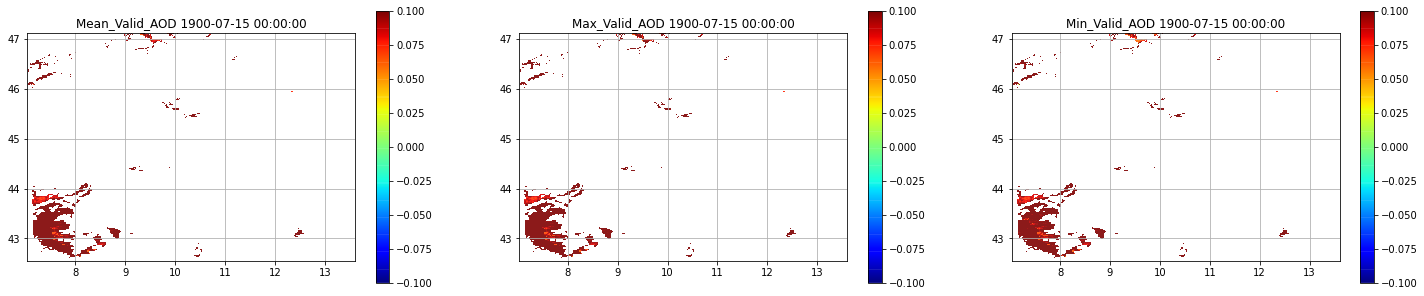

In [221]:
## Plot Valid MODIS Data (mean,maximum,minimium)
modis_products = ['Mean_Valid_AOD', 'Max_Valid_AOD', 'Min_Valid_AOD']
fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 2

normalisations = [dict(vmin=np.min(MODIS_Stats.data[modis_product]), 
                       vmax=np.max(MODIS_Stats.data[modis_product])) 
                  for modis_product in modis_products]


for nn, (fname, norm) in enumerate(zip(modis_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=MODIS_Stats, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])
    


In [222]:
## Temporal linear interpolation
from eolearn.features import LinearInterpolation, BSplineInterpolation

for m in modis_products:
    linear_interp = LinearInterpolation(m,mask_feature=(FeatureType.MASK, 'Daily_AOD_MASK'))
    linear_interp(MODIS_Stats)


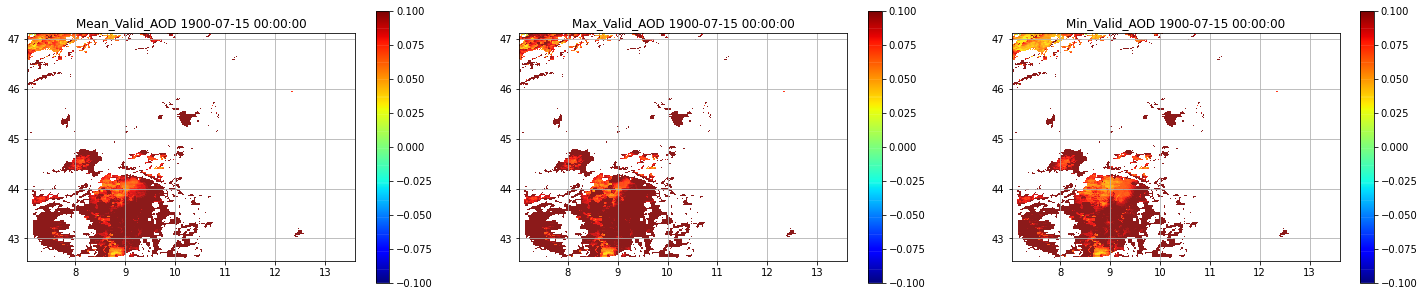

In [226]:
## Plot Interpolated MODIS Data, (mean,maximum,minimium)

fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 2

normalisations = [dict(vmin=np.min(MODIS_Stats.data[modis_product]), 
                       vmax=np.max(MODIS_Stats.data[modis_product])) 
                  for modis_product in modis_products]


for nn, (fname, norm) in enumerate(zip(modis_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=MODIS_Stats, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

#### Resampling MODIS data to 10 Km 

In [561]:
modis=target_size = bbox_to_dimensions(MODIS_Stats.bbox, 10000)

### ERA5 <a name="cams"></a>

### Land cover <a name="cams"></a>

### DEM <a name="cams"></a>

In [5]:
eu_dem_train_dir = DATA_DIR/AOIS[0]
print(eu_dem_train_dir)
eu_dem_eop = load_tiffs(eu_dem_train_dir, 
                        (FeatureType.DATA_TIMELESS, 'EU_DEM'),
                        filename='eu_dem_v11_North_Italy.zip')

training_dataset_ita/Italy


In [6]:
dem_target_size = bbox_to_dimensions(eu_dem_eop.bbox, 1000)


(519, 520)

### SPOT <a name="cams"></a>

### Data merging

## Exploratory analysis <a name="exploratory-analysis"></a>

## Modelling and validation <a name="modelling-and-validation"></a>

## Prediction <a name="prediction"></a>